# GRU(Gated Recurrent Units) 모델
- https://arxiv.org/pdf/1406.1078
- **LSTM은 RNN의 한계점인 기억력 소실문제를 해결하여 긴 sequence의 데이터에서도 좋은 성능을 내는 모델이다. 그러나 복잡한 구조로 parameter가 많아지게 되었고 연산량이 많은 문제점이 있다.**
    - parameter가 많아지면서 데이터양이 부족할 경우 과대적합이 발생하고 연산량이 많아 학습에 많은 시간이 걸리게 된다.
-** LSTM의 이런 문제를 개선하기 위한 변형 모델이 GRU이다.**

## LSTM과 차이
1. LSTM은 forget gate, input gate, output gete 세개의 Gate연산을 함. GRU는 **reset gate와 update gate** 로 흐름을 제어한다.
2. LSTM은 이전 처리결과로 Cell State, Hidden State 두개가 있었는데 이것을 하나로 합쳐 **Hidden State**로 출력한다.

## GRU 성능
- GRU는 적은 파라미터 수와 연산비용이 적게 드는 것에 비해 LSTM과 비슷한 성능을 내는 것으로 알려졌다.

## GRU Cell 구조

![gru_cell](figures/rnn/23_gru_cell.png)    
[이미지 Source](https://www.oreilly.com/library/view/advanced-deep-learning/9781789956177/8ad9dc41-3237-483e-8f6b-7e5f653dc693.xhtml)

입력값: 현재 입력값(X_t), 과거 특징 값(h_t-1)

update gate: 20% 기억함 = 80% 잊어버림 -> 80% 추가 (= (1-20)% 추가), LSTM은 forget과 input gate가 각각 따로 있었으나, GRU의 경우 reset gate에서 00% 기억, 1-00% 잊어버림 이런 식으로 간다. 

- **Reset Gate**
    - 이전 timestep까지의 hidden state(feature)를 현재 timestep의 hidden state(feature) 계산시 얼마나 반영할 지 비율을 결정하는 gate.
    - $r_{t} = \sigma(h_{t-1}\cdot U_{r} + X_{t}\cdot W_{r})$
        - $U_{r},\, W_{r}$ 는 파라미터
        - $\sigma$: sigmoid(logisic) 함수
- **Update Gate**
    - 현재 timestep의 hidden state($h_t$)를 계산할 때 이전 time step까지 정보($h_{t-1}$)와 현재 time step의 정보($X_t$)를 각각 얼마나 반영할지 비율을 정의한다.
    - $z_{t} = \sigma(h_{t-1}\cdot U_{z} + X_{t}\cdot W_{z})$
        - $U_{z},\, W_{z}$ 는 파라미터
        - $\sigma$: sigmoid(logisic) 함수
    - $h_t$를 계산할 때 $z_{t}$ 는 이전 정보인 $h_{t-1}$을 얼마나 반영할지 $1-z_{t}$는 현재 정보를 얼마나 반영할 지를 정한다.
- **Cell의 출력값인 $h_t$ 계산**
    - $z_{t}\times h_{t-1} + tanh(h_{t-1} * r_{t}+X_{t}\cdot W)\times(1-z_{t})$
    - 이전 정보에는 $z_t$를 곱해 얼마나 $h_t$ 에 더할지 연산
    - 현재 정보($X_t$)에는 이전 정보를 일부를 반영한다. 이전 정보를 얼마나 반영할지를 reset gate 결과를 곱해 결정한다. 활성화 함수 tanh를 이용해 비선형성을 추가 한 결과에 $1-z_t$를 곱한다.

## Pytorch GRU
- `nn.GRU` 클래스 이용
    - https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
- **입력**
    - **input**: (seq_length, batch, hidden_size) shape의 tensor. (batch_first=False), batch_first=True이면 `seq_length`와 `batch` 위치가 바뀐다.
    - **hidden**: (D * num_layers, batch, hidden_size) shape의 Tensor. D(양방향:2, 단방향:1), hidden은 생략하면 0이 입력됨.
- **출력** - output과 hidden state가 반환된다.
    - **output**
        - 모든 sequence의 처리결과들을 모아서 제공.
        - shape: (seq_length, batch, D * hidden_size) : D(양방향:2, 단방향:1), batch_first=True이면 `seq_length`와 `batch` 위치가 바뀐다.
    - **hidden**
        - 마지막 time step 처리결과
        - shape: (D * num_layers, batch, hidden) : D(양방향:2, 단방향:1)

In [2]:
## GRU 입출력  확인
import torch
import torch.nn as nn

# dummy data
input_data = torch.randn((20, 2, 10))  
# (20: seq len, 2: batch, 10: 개별 timestep의 입력 feature수)

In [3]:
gru1 = nn.GRU(
    input_size=10, # 개별 timestep의 Features (embedding) 
    hidden_size=256, # 각 timestep별로 256개 특성을  추출
    num_layers=1, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=False # 양방향 여부 (default: False)
)
out1, hidden1 = gru1(input_data)
#모든 timestep의 hidden state값을 묶어서 반환.[20:seq len, 2:batch, 256:hidden_size]
# hidden: 마지막 timestep을 준다. 
print(out1.shape) 
# 마지막 timestep 처리 hidden state값 [1: seq len, 2, 256]
print(hidden1.shape)

torch.Size([20, 2, 256])
torch.Size([1, 2, 256])


In [4]:
# bidirectional=True (양방향)
gru2 = nn.GRU(
    input_size=10,
    hidden_size=256, 
    num_layers=1, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=True # 양방향 여부 (default: False)
)
out2, hidden2 = gru2(input_data)

# [20,: seq_len, 2:batch, 512:hidden_size * 2]   양방향 hidden state를 합쳐서(concat) 반환.
print(out2.shape)
# [2:정/역방향 두개, 2, 256:hidden size]
print(hidden2.shape)

torch.Size([20, 2, 512])
torch.Size([2, 2, 256])


In [5]:
# 단방향 multi layer
gru3 = nn.GRU(
    input_size=10,
    hidden_size=256, 
    num_layers=4, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=False # 양방향 여부 (default: False)
)
out3, hidden3 = gru3(input_data)

#[20, 2, 256] - 마지막 GRU Layer가 출력한 결과들이 최종 feature이므로 그것을 모아서 반환.
# num_layers가 몇개든 out의 shape은 동일.
print(out3.shape)
# [4: 레이어수, 2, 256]  - 각 layer의 마지막 hidden state들을 모아서 반환
print(hidden3.shape)

torch.Size([20, 2, 256])
torch.Size([4, 2, 256])


In [6]:
# multi layer, 양방향

gru4 = nn.GRU(
    input_size=10,
    hidden_size=256, 
    num_layers=4, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=True # 양방향 여부 (default: False)
)
out4, hidden4 = gru4(input_data)
print(out4.shape) # [20, 2, 512: 양방향 hidden 합친것]
# [8:양방향(2) x 레이어수: 각각, 2, 256]
print(hidden4.shape)

torch.Size([20, 2, 512])
torch.Size([8, 2, 256])


Encoder-Decoder 구조 = Seq2Seq 구조라고 보면 된다~!

[원래값] ----- encode -----> [변환]    
        <---- decode -----

# Encoder-Decoder 구조
- 두개의 네트워크를 연결한 구조
- Encoder network는 입력을 이해하고 Decoder network는 (Encoder의 이해를 바탕으로) 출력을 생성한다.

## Seq2Seq
- Encoder-Decoder 구조를 RNN 계열에 적용한 모델.
- Encoder는 입력 Sequence의 전체 의미(특징)을 표현하는 **context vector**를 출력한다.
    - **Context Vector는**
        - 번역의 경우 번역할 대상 문장에서 **번역 결과를 만들때 필요한 feature들**을 가지고 있다.
        - Chatbot의 경우 입력된 질문에서 **답변을 만들때 필요한 feature들**을 가지고 있다.
- Decoder는 Encoder가 출력한 Context Vector를 입력받아 결과 sequence를 생성한다. ✅ Context Vector와 \<SOS\>를 입력 받아 결과 seq 생성
    - **결과 sequence는**
        - **번역**의 경우 번역 문장을 생성한다.
        - **chatbot**의 경우 질문에 대한 답변을 생성한다.

![seq2seq](figures/seq2seq.png)

# Seq2Seq 를 이용한 Chatbot 모델 구현
- Encoder를 이용해 질문의 특성을 추출하고 Decoder를 이용해 답변을 생성한다.

# Chatbot Dataset

- https://github.com/songys/Chatbot_data
- columns
    - Q: 질문
    - A: 답
    - label: 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2
- **Download**

![dataset](figures/chatbot.png)

# Chatbot Dataset Loading 및 확인

## 데이터 확인

In [7]:
# requests 모듈로 받기
import requests
import os

os.makedirs("data", exist_ok=True)

In [8]:
url = "https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv"
res = requests.get(url)
if res.status_code == 200:
    with open("data/chatbot_data.csv", "wt", encoding="utf-8") as fw:
        fw.write(res.text)
else:
    print(f"불러오지 못함: {url}")

In [9]:
import pandas as pd
df = pd.read_csv('data/chatbot_data.csv')
df.shape

(11823, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [11]:
# 라벨 컬럼 제거
df.drop(columns='label', inplace=True)

In [12]:
df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [13]:
df.tail()

,Q,A
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


In [14]:
df.isna().sum() # 결측치 확인 # 없네용 굿

Q    0
A    0
dtype: int64

# Dataset, DataLoader 정의

## Tokenization

### Subword방식

In [15]:
# token 학습 -> vocab 사전 생성.
## 질문들 + 답변들 합쳐서 학습.
question_texts = df['Q']
answer_texts = df['A']
all_texts = list(question_texts + " "+answer_texts) # 시리즈 + 시리즈 => 같은 index끼리 합치기 => list로 변환 (vocab)
len(question_texts), len(answer_texts), len(all_texts)

(11823, 11823, 11823)

In [16]:
all_texts[:5]

['12시 땡! 하루가 또 가네요.',
 '1지망 학교 떨어졌어 위로해 드립니다.',
 '3박4일 놀러가고 싶다 여행은 언제나 좋죠.',
 '3박4일 정도 놀러가고 싶다 여행은 언제나 좋죠.',
 'PPL 심하네 눈살이 찌푸려지죠.']

In [17]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

In [18]:
vocab_size = 10_000 # 총 어휘수
min_frequency = 5   # 어휘사전에 등록될 단어(토큰)의 최소 빈도수.

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    continuing_subword_prefix='##', # 연결 subword 앞에 붙일 접두어지정. 
    special_tokens=["[PAD]", "[UNK]", "[SOS]"] # [SOS]: 문장의 시작을 의미하는 토큰.
)
# tokenizer: token + ##izer
## 학습
tokenizer.train_from_iterator(all_texts, trainer=trainer) # 리스트로 부터 학습
## tokenizer.train("파일경로") # 파일에 있는 text를 학습.

In [19]:
print("총 어휘수:", tokenizer.get_vocab_size())

총 어휘수: 7040


In [20]:
# 토큰화
encode = tokenizer.encode("오늘 날씨가 너무 좋습니다. 즐거운 하루 되세요. 쿄쿄쿜ㅋ")
print(encode.ids)  # 토큰 id
print(encode.tokens)  # 토큰 (단어어)

[2290, 3852, 2258, 5913, 8, 3271, 2447, 322, 2243, 8, 1, 1, 1, 1865]
['오늘', '날씨가', '너무', '좋습니다', '.', '즐거운', '하루', '되', '##세요', '.', '[UNK]', '[UNK]', '[UNK]', '##ㅋ']


In [21]:
tokenizer.id_to_token(2290), tokenizer.token_to_id("오늘")

('오늘', 2290)

### Tokenizer 저장

In [22]:
dir_path = "saved_model/chatbot/vocab"
os.makedirs(dir_path, exist_ok=True)
vocab_path = os.path.join(dir_path, "chatbot_bpe.json")
tokenizer.save(vocab_path)

In [23]:
question_texts, answer_texts

(0                         12시 땡!
 1                    1지망 학교 떨어졌어
 2                   3박4일 놀러가고 싶다
 3                3박4일 정도 놀러가고 싶다
 4                        PPL 심하네
                   ...           
 11818             훔쳐보는 것도 눈치 보임.
 11819             훔쳐보는 것도 눈치 보임.
 11820                흑기사 해주는 짝남.
 11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
 11822                 힘들어서 결혼할까봐
 Name: Q, Length: 11823, dtype: object,
 0                      하루가 또 가네요.
 1                       위로해 드립니다.
 2                     여행은 언제나 좋죠.
 3                     여행은 언제나 좋죠.
 4                      눈살이 찌푸려지죠.
                    ...           
 11818          티가 나니까 눈치가 보이는 거죠!
 11819               훔쳐보는 거 티나나봐요.
 11820                      설렜겠어요.
 11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
 11822          도피성 결혼은 하지 않길 바라요.
 Name: A, Length: 11823, dtype: object)

## Dataset, DataLoader 정의


### Dataset 정의 및 생성
- 모든 문장의 토큰 수는 동일하게 맞춰준다.
    - DataLoader는 batch 를 구성할 때 batch에 포함되는 데이터들의 shape이 같아야 한다. 그래야 하나의 batch로 묶을 수 있다.
    - 문장의 최대 길이를 정해주고 **최대 길이보다 짧은 문장은 `<PAD>` 토큰을 추가**하고 **최대길이보다 긴 문장은 최대 길이에 맞춰 짤라준다.**

In [24]:
import random
import os
import numpy as np
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [25]:
class ChatbotDataset(Dataset):
    """
    ChatbotDataset
    parameter:
        question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
        answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
        max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
        tokenizer: Tokenizer
        vocab_size: int 총단어수
    """

    def __init__(self, question_texts, answer_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        # 받아온 q/a 문장 리스트를 max_length의 token list로 변환해서 attribute로 저장.ㅠ
        self.question_texts = [self.__process_sequence(q) for q in question_texts]
        self.answer_texts = [self.__process_sequence(a) for a in answer_texts]
    
    def __pad_token_sequence(self, token_sequence): 
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.
        
        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]') # [PAD] 토큰 id를 조회 (0)
        seq_len = len(token_sequence) # 입력 문장의 토큰수
        if seq_len > self.max_length: # 문장 최대 토큰수 보다 길다면.
            return token_sequence[:self.max_length] # 슬라이싱 해서 조회회
        else:
            return token_sequence + ([pad_token] * (self.max_length - seq_len)) # 빈 부분은 [PAD] 토큰 붙이기
    
    def __process_sequence(self, text): 
        """
        한 문장(str)을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        # encoding
        encode = self.tokenizer.encode(text) # "........" => [. , . , .]
        # max_length 크기에 맞춘다.
        token_ids = self.__pad_token_sequence(encode.ids) #[3400, 20, 6, 0, 0, 0 ..]
        return token_ids
    
    def __len__(self):
        return len(self.question_texts)

    
    def __getitem__(self, index):
        # return  index의 (질문토큰들,  답변토큰들)
        q = self.question_texts[index]  # List
        a = self.answer_texts[index]
        # List->LongTensor. nn.Embedding()의 입력(정수타입)으로 들어간다. 
        return torch.tensor(q, dtype=torch.int64), torch.tensor(a, dtype=torch.int64)
        

In [26]:
# 적당한 max_length 값: 전체 문장 총 토큰수의 9분위수
import numpy as np
a = [len(tokenizer.encode(s).ids) for s in all_texts]
# a[:5]
np.quantile(a, q=[0.9, 0.95, 1.0])
# max_length=20

array([17., 19., 41.])

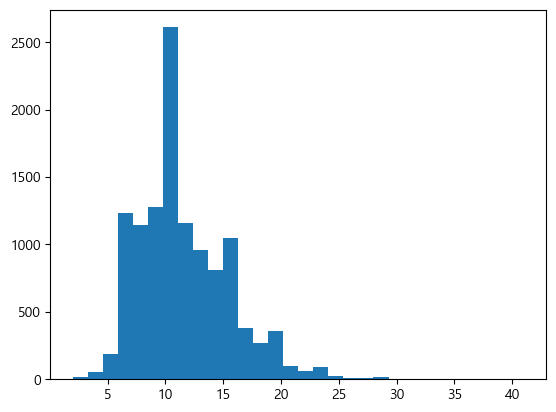

In [27]:
import matplotlib.pyplot as plt
plt.hist(a, 30);

In [28]:
############# Dataset 셍상
MAX_LENGTH = 20
dataset = ChatbotDataset(question_texts, answer_texts, MAX_LENGTH, tokenizer)
len(dataset)

11823

In [29]:
dataset[0] # 첫 번째 tensor가 질문, 두 번째 tensor가 답변임.

(tensor([  10, 1780, 1414,  368,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([6119,  378,   47, 2252,    8,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]))

### Trainset / Testset 나누기
train : test = 0.95 : 0.05

In [30]:
int(len(dataset) * 0.95)
len(dataset) - int(len(dataset) * 0.95)

592

In [31]:
train_size = int(len(dataset)*0.95) # trainset의 개수
test_size = len(dataset) - train_size # testset의 개수
print(train_size, test_size)

11231 592


In [32]:
# random_split()이용해서 분리
###shuffle 후 개수에 맞게 나눔 -> 순서대로 나누지 않는다.
train_set, test_set = random_split(dataset, [train_size, test_size]) 
# random_split(Dataset객체, [나눌개수, ...])
# random_split(dataset, [10, 20, 30, 40, 50]) # 5개로 나눔. 각각 개수가 지정한 개수.

In [33]:
type(dataset), type(train_set)

(__main__.ChatbotDataset, torch.utils.data.dataset.Subset)

In [34]:
len(train_set), len(test_set)

(11231, 592)

### DataLoader 생성

In [35]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [36]:
len(train_loader), len(test_loader) # step 수

(175, 10)

# 모델 정의

## Seq2Seq 모델 정의
- Seq2Seq 모델은 Encoder와 Decoder의 입력 Sequence의 길이와 순서가 자유롭기 때문에 챗봇이나 번역에 이상적인 구조다.
    - **단일 RNN은 각 timestep 마다 입력과 출력이 있기 때문에 입/출력 sequence의 개수가 같아야 한다.**
    - ⭐**챗봇의 질문/답변이나 번역의 대상/결과 문장의 경우는 사용하는 어절 수가 다른 경우가 많기 때문에 단일 RNN 모델은 좋은 성능을 내기 어렵다.**
    - ⭐ Seq2Seq는 **입력처리(질문,번역대상)처리 RNN과 출력 처리(답변, 번역결과) RNN 이 각각 만들고 그 둘을 연결한 형태로 길이가 다르더라도 상관없다.**

Many to Many 모델로 하면 안 되나요 -> 질문 토큰이 들어가면 그에 맞게 답변 토큰을 출력하는 건데, 그러면 질문 토큰과 답변 토큰의 수가 같아야만 함 -> seq2seq은 입출력 길이에 보다 자유롭다~!!

## Encoder: Feature Vector 추출
Encoder는 하나의 Vector를 생성하며 그 Vector는 **입력 문장의 의미**를 N 차원 공간 저장하고 있다. 이 Vector를 **Context Vector** 라고 한다.    
Many to One 구조가 된다.    
![encoder](figures/seq2seq_encoder.png)

In [37]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim, 
                 hidden_size, bidirectional=True, num_layers=1, dropout_rate=0.0):
        super().__init__()
        # Encoder는 context vector(문장의 feature)를 생성하는 것이 목적 (분류기는 생성안함.)
        # Embedding Layer, GRU Layer를 생성.
        self.vocab_size = vocab_size # 어휘사전의 총 어휘수(토큰수)
        # 임베딩레이어
        self.embedding = nn.Embedding(
            vocab_size,      # 총 어휘 개수(Weight 행렬의 행 수수)
            embedding_dim,   # embedding vector 차원 수. (Weight 행렬의 열 수) # Weight 행렬의 shape: [vocab_size, embedding_dim]
            padding_idx=0    # [PAD] 패딩 토큰의 ID - padding의 embedding vector는 학습이 안 되도록 한다. 따라서 벡터 값이 0으로 구성된다. 
        )
        # GRU
        self.gru = nn.GRU(
            input_size=embedding_dim, # 개별 토큰(time_step)의 크기(feature 수)
            hidden_size=hidden_size, # hidden state의 크기 - 개별 토큰별로 몇 개의 featre를 추출할지를 지정.
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_layers > 1 else 0.0 # stacked rnn일 경우 dropout을 적용하겠다.
        )
    
    def forward(self, X):
        # X shape: (batch, seq_len)
        X = self.embedding(X) # (batch, seq_len, embedding_dim)
        X = X.transpose(1, 0) # (seq_len, batch, embedding_dim)
        out, hidden = self.gru(X)
        return out, hidden

In [38]:
e_l = nn.Embedding(10, 5, padding_idx=0)
e_l.weight # 0번 인덱스인 패딩 벡터만 0벡터이다!!

Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.3946e+00,  1.7776e+00,  1.4087e-01,  8.0869e-01,  3.9893e-01],
        [ 7.3057e-01, -1.4297e-01, -2.1161e+00, -1.7540e-02,  1.2523e+00],
        [ 1.2237e+00, -1.6332e+00,  1.2314e+00,  6.4199e-01,  8.2362e-01],
        [ 5.7164e-01,  9.0305e-01, -1.3142e-01,  4.1697e-01, -6.7883e-01],
        [ 2.7817e-01, -2.5843e-02,  3.4209e-01,  1.5360e+00,  9.8002e-01],
        [ 6.0593e-01,  9.4008e-05, -5.5632e-01,  5.2691e-01, -7.6997e-01],
        [ 1.3705e+00,  2.1861e-02,  7.7982e-01,  1.7241e+00, -7.3699e-01],
        [ 1.5076e+00,  2.1645e-01, -3.8954e-01,  8.6803e-01,  1.7072e+00],
        [-7.8554e-01, -2.2762e-01, -2.2893e-01, -3.6735e-01,  1.2994e-02]],
       requires_grad=True)

In [39]:
from torchinfo import summary
encoder_model = Encoder(1000, 200, 256) # vocab size: 1000, emb 차원: 200, hidden size: 256                                     
dummy_data = torch.zeros((64, 20), dtype=torch.int64)  #(batch:64, seq_len:20)
summary(encoder_model, input_data=dummy_data)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [20, 64, 512]             --
├─Embedding: 1-1                         [64, 20, 200]             200,000
├─GRU: 1-2                               [20, 64, 512]             703,488
Total params: 903,488
Trainable params: 903,488
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 913.26
Input size (MB): 0.01
Forward/backward pass size (MB): 7.29
Params size (MB): 3.61
Estimated Total Size (MB): 10.92

## Decoder: Feature Vector 받아서 결과 출력
- Encoder의 출력(context vector)를 받아서 번역 결과 sequence를 출력한다.
- Decoder는 매 time step의 입력으로 **이전 time step에서 예상한 단어와 hidden state값이** 입력된다.
- Decoder의 처리결과 hidden state를 Estimator(Linear+Softmax)로 입력하여 **입력 단어에 대한 번역 단어가 출력된다.** (이 출력단어가 다음 step의 입력이 된다.)
    - Decoder의 첫 time step 입력은 문장의 시작을 의미하는 <SOS>(start of string) 토큰이고 hidden state는 context vector(encoder 마지막 hidden state) 이다.

![decoder](figures/seq2seq_decoder.png)

In [40]:
class Decoder(nn.Module):
    # auto regressive model은 단방향만 가능하다 => bidirectional=False
    def __init__(self, vocab_size, embedding_dim, 
                 hidden_size, num_layers=1, bidirectional=False, dropout_rate=0.0):
        super().__init__()
        self.vocab_size = vocab_size # 총 어휘사전 토큰 개수.
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # GRU 
        ## Auto Regressive RNN은 단방향만 가능. 
        self.gru = nn.GRU(
            embedding_dim, 
            hidden_size, 
            num_layers=num_layers, 
            dropout=dropout_rate if num_layers > 1 else 0.0
            )
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        # 분류기 (다음 단어(토큰)를 추론)
           # - 다중분류(단어사전의 단어들의 다음 단어일 확를)
        self.lr = nn.Linear(
            hidden_size,  # GRU 출력 값 중 마지막 hidden state값을 입력으로 받음.
            vocab_size    # 출력: 다음 단어일 확률. 
        )
        
    def forward(self, X, hidden):
        # X: torch.LongTensor: shape - [batch] : "한 단어씩" 입력을 받음.
        # hidden: torch.FloatTensor: shape - [1, batch, hidden_size] (이전까지의 특성)
        
        X = X.unsqueeze(1) # seq_len 축을 추가. [batch] -> [batch, 1] (Embedding Layer의 input shape)
        X = self.embedding(X) # [batch, 1, embedding 차원] # embedding에 넣을 때 seq_len = 1이므로, 위에서 unsqueezed 해주는 거!
        X = X.transpose(1, 0) # [1, batch, embedding 차원]
        
        out, hidden = self.gru(X, hidden) # hidden은 함수 파라미터로 받은 거 넣어준다. 
        last_out = out[-1] # out: 전체 hidden state값-> 마지막 hidden state을 추출
        self.dropout(last_out) # weight에 대한 과적합을 막아주기 위함. 
        last_out = self.lr(last_out)

        # last_out: 어휘사전의 단어들에 대해 다음 단어일 확률.
        return last_out, hidden # (hidden: 다음 timestep에 전달.)

In [41]:
#### summary

decoder_model = Decoder(1000, 200, 256)

dummy_input = torch.ones((64, ), dtype=torch.int64)
dummy_hidden = torch.ones((1, 64, 256), dtype=torch.float32)

summary(decoder_model, input_data=(dummy_input, dummy_hidden))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 1000]                --
├─Embedding: 1-1                         [64, 1, 200]              200,000
├─GRU: 1-2                               [1, 64, 256]              351,744
├─Dropout: 1-3                           [64, 256]                 --
├─Linear: 1-4                            [64, 1000]                257,000
Total params: 808,744
Trainable params: 808,744
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.76
Input size (MB): 0.07
Forward/backward pass size (MB): 0.75
Params size (MB): 3.23
Estimated Total Size (MB): 4.05

## Seq2Seq 모델

- Encoder - Decoder 를 Layer로 가지며 Encoder로 질문의 feature를 추출하고 Decoder로 답변을 생성한다.

### Teacher Forcing
- **Teacher forcing** 기법은, RNN계열 모델이 다음 단어를 예측할 때, ⭐이전 timestep에서 예측된 단어를 입력으로 사용하는 대신 **실제 정답 단어(ground truth) 단어를** 입력으로 사용⭐하는 방법이다.
    - 모델은 이전 시점의 출력 단어를 다음 시점의 입력으로 사용한다. 그러나 모델이 학습할 때 초반에는 정답과 많이 다른 단어가 생성되어 엉뚱한 입력이 들어가 학습이 빠르게 되지 않는 문제가 있다.
- **장점**
    - **수렴 속도 증가**: 정답 단어를 사용하기 때문에 모델이 더 빨리 학습할 수있다.
    - **안정적인 학습**: 초기 학습 단계에서 모델의 예측이 불안정할 때, 잘못된 예측으로 인한 오류가 다음 단계로 전파되는 것을 막아줍니다.
- **단점**
    - **노출 편향(Exposure Bias) 문제:** 실제 예측 시에는 정답을 제공할 수 없으므로 모델은 전단계의 출력값을 기반으로 예측해 나가야 한다. 학습 과정과 추론과정의 이러한 차이 때문에 모델의 성능이 떨어질 수있다.
        - 이런 문제를 해결하기 학습 할 때 **Teacher forcing을 random하게 적용하여 학습시킨다.**
![seq2seq](figures/seq2seq.png)

In [52]:
SOS_TOKEN = tokenizer.token_to_id("[SOS]")
SOS_TOKEN

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        
    def forward(self, inputs, outputs, teacher_forcing_rate=0.99):
        """
        parameter
            inputs: 질문 - (batch, seq_length)
            outputs: 답변(정답) - (batch, seq_length)
            teacher_forcing_rate: teacher_forcing 적용 확률.
        """
        # 질문
        if inputs.dim() == 1: # (seq_length) # 질문이 한개일 경우 질문 문장 토큰만 입력될 수있다.
            inputs = inputs.unsqueeze(0) # (1: batch, seq_length)
        
        # 답변
        if outputs.dim() == 1:
            outputs = inputs.unsqueeze(0)

        batch_size, output_length = outputs.shape    # output_length: 답변 문장의 토큰수 == 생성할 답변의 토큰수
        output_vocab_size = self.decoder.vocab_size  # 어휘사전 토큰 총 개수.

        # 생성된 문장을 저장할 변수
        ## (seq length, batch size, vocab_size(단어별 확률))
        ## 일단 값을 0으로 채워넣고 시작, 학습하며 점차 채워넣음.
        predicted_outputs = torch.zeros(output_length, batch_size, output_vocab_size).to(self.device)

        ###### encoder를 이용해서 질문 문장의 context vector 추출.
        encoder_out, encoder_hidden = self.encoder(inputs)
        # encoder_out(모든 timestep의 hidden state들): [seq_len, batch, hidden_size * 2(양방향-단방향:1)]
        # encoder_hidden(마지막 timestep의 hidden state들): [2(양방향-단방향:1), batch, hidden_size]

        # Decoder의 첫번째 hidden state 값 -> Context Vector
        decoder_hidden = encoder_out[-1].unsqueeze(0) # [1, batch, hidden] #마지막 hidden state == Context Vector(문맥==전체문장==정보)
        # Decoder에 넣을 첫번째 time step의 값: [SOS]
        decoder_input = torch.full((batch_size, ), fill_value=SOS_TOKEN, device=self.device)

        # 순회(반복) 하면서 단어들을 하나씩 생성. 
        for t in range(output_length): # max_length 만큼 생성.
            # decoder_input(개별토큰id): [batch_size] - 첫 timestep: [SOS], 두번째: 생성된 토큰
            # decoder_out(batch_size, vocab_size): 다음 단어일 확률
            # decoder_hidden(1, batch, hidden * 2(양방향, 단: 1)) - 현재 입력의 feature(다음 timestep의 hidden으로 사용)
            decoder_out, decoder_hidden = self.decoder(decoder_input, decoder_hidden) 

            predicted_outputs[t] = decoder_out # t 번째 예측 단어(확률값)를 저장.

            #### 다음 timestep에 넣어줄 값을 생성. 
            ##### teacher_forcing 적용: 정답, 비적용: 모델이 추론한 결과
            teacher_forcing = teacher_forcing_rate > random.random() # Teacher Forcing 적용 여부 (bool)
            # teacher_forcing_rate의 확률만큼 True. 
            teacher_forcing_rate = teacher_forcing_rate * 0.99 
            # 점점 teacher forcing이 적용될 가능성을 줄인다.
                          #    (모델이 추론한 값이 다음 입력으로 사용할 확률을 높여준다.)

            # 모델이 추론한 단어중 가장 확률이 높은(TOP-1) 단어를 추출 
            top1 = decoder_out.argmax(-1)
            # teacher_foring이 True: 정답, False: 예측(top1)
            decoder_input = outputs[:, t] if teacher_forcing else top1

        return predicted_outputs.transpose(1, 0) # (batch, seq_length, vocab_size) 변환.

In [53]:
# random.random() # 랜덤값생성-0 ~ 1 실수를 반환. 모든 값들이 나올 확률은 동일 - 균등분포

# 학습

## 모델생성

In [54]:
#  하이퍼파라미터들 정의
VOCAB_SIZE = tokenizer.get_vocab_size()

ENCODER_BIDIRECTIONAL = True # 인코더 양방향 여부
ENCODER_HIDDEN_SIZE = 200    # 인코더 hidden_size
# DECODER의 hidden size는 encoder의 마지막 timestep의 hidden size에 맞춰준다
DECODER_HIDDEN_SIZE = ENCODER_HIDDEN_SIZE * 2 if ENCODER_BIDIRECTIONAL else ENCODER_HIDDEN_SIZE
EMBEDDING_DIM = 256  # 임베딩 차원수
TEACHER_FORCING_RATE = 0.9

In [45]:
tokenizer.get_vocab_size()

7040

In [55]:
### 모델 생성
encoder = Encoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=ENCODER_HIDDEN_SIZE,
    num_layers=1,
    bidirectional=ENCODER_BIDIRECTIONAL
)
decoder = Decoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=DECODER_HIDDEN_SIZE,
    num_layers=1  # auto regressive 모델이므로 단방향 GRU생성. 
) # bidirectional=False(default)
model = Seq2Seq(encoder, decoder, device)

In [56]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7040, 256, padding_idx=0)
    (gru): GRU(256, 200, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7040, 256, padding_idx=0)
    (gru): GRU(256, 400)
    (dropout): Dropout(p=0.0, inplace=False)
    (lr): Linear(in_features=400, out_features=7040, bias=True)
  )
)


## loss함수, optimizer

In [57]:
LR = 0.001
model = model.to(device)
# 다음 단어를 추론하는 다중분류
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## train/evaluation 함수 정의

### train 함수정의

In [ ]:
# 1 epoch 학습 함수.
def train_fn(model, data_loader, optimizer, loss_fn, device, 
             teacher_forcing_rate=0.99):

    model.train()  # Seq2Seq모델.
    loss_list = [] # step별 loss를 저장.

    for X, y in data_loader: # X: 질문, y: 답변
        # device 로 이동
        X, y = X.to(device), y.to(device)
        # 추론
        pred = model(X, y, teacher_forcing_rate)
        # pred: 추론한 답변 문장: (batch, seq_length, vocab_size:토큰일 확률)
        
        # pred와 정답의 shape을 변경 (loss 함수에 넣을 수 있는 shape으로 변환.)
        # pred를 reshape (batch, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
        y_hat = pred.reshape(-1, pred.shape[2]) 
        # 정답(y)을 reshape (batch, seq_len:토큰수) -> (batch * seq_len)
        y = y.reshape(-1)
        # CrossEntropyLoss(): 정답 - 원핫인코딩 안된 형태, 추론값: softmax 처리 안된 상태
        #       - 정답  shape: (batch, ) ======> (batch * seq_len)
        #       - 추론값shape: (batch, class개수)  ==> (batch * seq_len, class 개수 - vocabsize)

        # Loss 계산
        loss = loss_fn(y_hat, y)
        # gradient 계산
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 파라미터 초기화
        optimizer.zero_grad()
        loss_list.append(loss.item())
    return np.mean(loss_list).item()

### Test 함수

In [58]:
def test_fn(model, data_loader, loss_fn, device):
    
    # 1 에폭 테스트
    model.eval()
    loss_list = []

    with torch.no_grad():
        for X, y in data_loader:
            # 이동
            X, y = X.to(device), y.to(device)
            pred = model(X, y, teacher_forcing_rate=0.0) 
            # 왜 0.0? 추론 답변 생성: decoder가 생성한 단어를 다음 단어로 넣어서 추정
            # teacher forcing은 train시에만 적용!!!

            # loss 계산
            # y와 pred의 shape을 CrossEntropyLoss 입력에 맞게 reshape
            y_hat = pred.reshape(-1, pred.shape[2])
            y = y.reshape(-1)
            loss_list.append(loss_fn(y_hat, y).item())
    
    return np.mean(loss_list)

### Training

In [60]:
EPOCHS = 1
MODEL_SAVE_PATH = 'saved_model/chatbot/seq2seq-chatbot-model.pt'

best_loss = np.inf
s = time.time()

for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, loss_fn, 
                          device, TEACHER_FORCING_RATE)
    val_loss = test_fn(model, test_loader, loss_fn, device)

    # 저장
    if val_loss < best_loss:
        torch.save(model, MODEL_SAVE_PATH)
        print(f"{epoch}에서 저장. {best_loss:.5f}에서 {val_loss:.5f}로 개선됨.")
        best_loss = val_loss

    print(f"[{epoch}/{EPOCHS}] train loss: {train_loss}, val loss: {val_loss}")

e = time.time()
print("걸린시간:", (e-s))

0에서 저장. inf에서 2.54786로 개선됨.
[0/1] train loss: 1.9775814362934658, val loss: 2.547860026359558
걸린시간: 72.5538079738617


In [ ]:
MODEL_SAVE_PATH_LAST = 'saved_model/chatbot/seq2seq-chatbot-model_last.pt'
torch.save(model, MODEL_SAVE_PATH_LAST)

In [ ]:
## 저장 모델 Load
device = "cuda" if torch.cuda.is_available() else "cpu"
# map_location=device : 다른 device에 학습/저장한 것을 읽어올 때 현재 device를 지정해서 
#                                                현재 device에 맞춰 load하도록한다.
best_model = torch.load(MODEL_SAVE_PATH, weights_only=False, map_location=device)
best_model.device = device # Attribute device를 현재 device로 지정.

last_model = torch.load(MODEL_SAVE_PATH_LAST, weights_only=False, map_location=device)
last_model.device = device # Attribute device를 현재 device로 지정.

# 결과확인

In [ ]:
from torch.utils.data import SubsetRandomSampler

def handle_special_tokens(decoded_string):
    """
    Subword 처리
    subword는 단어의 시작으로 쓰인 것과 중간 부분(연결)에 사용된 두가지 subword가 있다.  연결 subword는 `#`과 같은 특수문자로 시작 한다.
    tokenizer.decode() 결과 문자열은 subword의 특수문자('##')을 처리하지 않는다. 이것을 처리하는 함수
    ex) "이 기회 ##는 내 ##꺼 #야" ==> "이 기회는 내꺼야"
    
    Parameter
        decoded_string: str - Tokenizer가 decode한 중간 subword의 특수문자 처리가 안된 문자열. 
    Return
        str: subword 특수문자 처리한 문자열
    """
    
    tokens = decoded_string.split() # 공백기준으로 토큰화.
    new_tokens = []
    for token in tokens:
        if token.startswith("##"): # 연결 토큰
            if new_tokens: # len(new_tokens) != 0 원소가 하나라도 있으면
                # 토큰에서 ##을 제거하고 리스트의 마지막 원소(문자열) 뒤에 붙인다.
                new_tokens[-1] += token[2:]
            else: # new_tokens가 빈 리스트. 현재 token이 첫번째 단어. ##을 지우고 append
                new_tokens.append(token[2:])
        else: # 단어의 시작인 토큰. (##이 없는 토큰) -> list에 추가.
            new_tokens.append(token)
        
    return " ".join(new_tokens) 
    

# dataset에서 일부 데이터들을 가지고 확인
def random_evaluation(model, dataset, device, n=10):
    """
    Dataset에서 일부 질문-답변 쌍들을 가져다 모델에 질문을 넣어 추론한 결과와 함께 확인.
    Parameter
        model: 학습된 seq2seq 모델
        dataset: 질문-답변 쌍울 추출할 dataset
        device
        n: int - 추출할 질문-답변 쌍 개수 default: 10
    """
    ## 평가할 데이터셋을 만들기
    n_samples = len(dataset)       # Dataset의 총 데이터개수
    index = list(range(n_samples)) # Dataset의 index만들기. [0, 1, 2, ..., dataset_length]
    np.random.shuffle(index)       # 값들을 랜덤하게 섞어준다. [100, 23, 590, 10, ... ]
    sample_index = index[ : n]     # 평가할 데이터 개수만큼 index 생성.
    
    # Dataloader 생성
    # SubsetRandomSampler: 지정한 index들 안에서 random한 순서로 제공.
    # sample_index = [1, 20, 4, 5, 100], dataset에서 [1, 20, 4, 5, 100] index 값만 추출
    sampler = SubsetRandomSampler(sample_index)
    sample_loader = DataLoader(dataset, batch_size=n, sampler=sampler)
    
    ## 추론 후 확인
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in sample_loader:
            X, y = X.to(device), y.to(device)
            output = model(X, y, 0.0) # [batch, seq_len, vocab_size]

            # torch.Tensor -> ndarray (tokenizer decode에 넣기 위해.)
            ## tensor를 cpu로 이동후 변환가능.
            ### tensor가 grad를 가지고 있으면(계산그래프에 포함되 있으면)
            ####                               -> tensor.detach().cpu().ndarray()
            pred = output.cpu().numpy()  # X.to("cpu") # 모델 추정 답변
            X = X.cpu().numpy() # 정답 - 질문
            y = y.cpu().numpy() # 정답 - 답변

            for i in range(n):
                q = handle_special_tokens(tokenizer.decode(X[i]))
                a = handle_special_tokens(tokenizer.decode(y[i]))
                p = handle_special_tokens(tokenizer.decode(pred[i].argmax(-1)))
                print(f"질문: {q}")
                print(f"정답: {a}")
                print(f"예측: {p}")
                print('==================================================')

In [62]:
handle_special_tokens("이 기회 ##는 내 ##꺼 ##야")

'이 기회는 내꺼야'

In [67]:
sampler = SubsetRandomSampler([1, 2])
sample_loader = DataLoader(train_set, batch_size=2, sampler=sampler)
a = next(iter(sample_loader))

데이터셋에 있는 1, 2번 인덱스만 순서 바꿔가면서 줘!

In [68]:
a

[tensor([[3102, 3371,  966, 1409, 2815, 3573, 1250, 3197,    8,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [6748, 1200, 2092, 6056, 2347, 1282,   20,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0]]),
 tensor([[6279, 7038, 2454, 3944,    8,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [5405, 3172, 2440,    8,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0]])]

왜 이걸 써요?: 데이터셋을 전부 다 쓸 수 없어서 일부만 써보려고

- Sampler:
    -  DataLoader가 Datatset의 값들을 읽어서 batch를 만들때 index 순서를 정해주는 객체.
    -  DataLoader의 기본 sampler는 SequentialSampler 이다. shuffle=True 일경우 RandomSampler: 랜덤한 순서로 제공.

In [69]:
random_evaluation(model, train_set, device)

질문: 전여친한테 연락하고 싶어
정답: 연락하면 지긋지긋한 사람으로 기억될 거예요 .
예측: 좋은 수 있을 거예요 .
질문: 끝나면 좋을 줄 알았는데 .
정답: 마음이 허전하신가봐요 .
예측: 좋은 수 있을 거예요 .
질문: 언제쯤 이 끈을 놓아야할까 . 지금일까 .?
정답: 달라지지 않는다면 빠를수록 덜 힘들거예요 .
예측: 그이 수 있을 거예요 .
질문: 고구마 다이어트 해야지
정답: 너무 무리하지는 마세요 .
예측: 좋은 수 있을 거예요 .
질문: 부모님한테 반항했어
정답: 나중에 후회할 거예요 .
예측: 좋은 수 있을 거예요 .
질문: 회 먹으러 가야겠다 .
정답: 맛나게 드세요 .
예측: 좋은 수 있을 거예요 .
질문: 1년째 동거중이야
정답: 서로 알아가는 단계인가봐요 .
예측: 좋은 수 있을 거예요 .
질문: 급 내 짝남 생각나는 일화가 .
정답: 말씀 해보세요 .
예측: 좋은 수 있을 거예요 .
질문: 고백했다 차이면 어쩌지 ?
정답: 진심으로 고백하면 좋은 결과가 있을 거예요 .
예측: 그이 수 있을 거예요 .
질문: 결국 파혼했어 !
정답: 마음이 더 복잡하겠어요 .
예측: 좋은 수 있을 거예요 .


In [70]:
random_evaluation(model, test_set, device)

질문: 지는 게 진짜 싫어
정답: 질 때도 있고 이길 때도 있는 거예요 .
예측: 좋은 수 있을 거예요 .
질문: 눈이 너무 나빠졌어
정답: 잠시 눈을 감고 휴식을 취해보세요 .
예측: 좋은 수 있을 거예요 .
질문: 상처받았어
정답: 다른 사람 말은 신경쓰지 마세요 .
예측: 좋은 수 있을 거예요 .
질문: 왜 이렇게 무기력하죠
정답: 이별은 사람을 무기력하게 해요 .
예측: 좋은 수 있을 거예요 .
질문: 현실적인 문제에 헤어짐이 다가오고 있어 . 결국 이별일텐데
정답: 현실적인 문제가 중요할 때가 있죠 .
예측: 좋은 수 있을 거예요 .
질문: 친구가 내 썸남이랑 연락해
정답: 도와주려는 것일 수도 있어요 .
예측: 좋은 수 있을 거예요 .
질문: 복수전공하고 싶어
정답: 학점 관리하세요 .
예측: 좋은 수 있을 거예요 .
질문: 넘넘 외로워 죽겠어
정답: 외로우니까 사람이다 .
예측: 좋은 수 있을 거예요 .
질문: 헤어지고 3개월만에 만나고 왔어
정답: 더 힘들겠네요 .
예측: 좋은 수 있을 거예요 .
질문: 몸이 멀어지면 마음도 멀어진다는말 어떻게 생각하세 ?
정답: 아무래도 그런 것 같아요 .
예측: 그이 수 있을 거예요 .


In [ ]:
print("=============Last Model=================")
random_evaluation(last_model, test_set, device)

=============Last Model=================
질문: 싸운다의 기준이 뭘까 ?
정답: 감정이 상하면 싸우는 거죠 .
예측: 직접 물어보세요 .
질문: 술만 먹으면 집에 늦게 와
정답: 몸에 해로우니 적게 먹는 게 좋겠다고 말해보세요 .
예측: 좋은 결과 있을 거예요 .
질문: 더 많이 좋아하고 덜 많이 좋아하는 거 그만합시다
정답: 사랑을 재다보면 스스로가 더 힘들거예요 .
예측: 달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .
질문: 좋아하는 여자애한테 화이트데이 때 사탕 주면 좋아할까 ?
정답: 주면 좋아할 거예요 .
예측: 직접 물어보는 게 좋을 것 같아요 .
질문: 취향 알고 싶다
정답: 직접 물어보세요 .
예측: 성공을 기원합니다 .
질문: 헤어져야 하나 .
정답: 서로의 관계에 대해 생각해보세요 .
예측: 많이 힘들었죠 .
질문: 좋아했던 사람도 금방 잊을 수 있을까 .
정답: 아무래도 시간이 필요하겠죠 .
예측: 잘 버티고 있는거라 믿어요 .
질문: 짝남이 좋아하는 사람이 있대요 .
정답: 저까지 마음이 안좋네요 .
예측: 마음을 단단히 하니까요 .
질문: 솔로 7개월 넘어가네
정답: 충분히 좋은 사람 만날 수 있을 거예요 .
예측: 그 사람에게 찾아가 보세요 .
질문: 소원하는 대로 이루어졌으면 .
정답: 사는 재미가 없을거예요 .
예측: 건강 생각해서 챙겨드세요 .


# 새로운 데이터 추론

In [71]:
class ChatbotInputDataset(Dataset):
    """
    질문만 받아서 생성하는 Dataset
    - 새로운 데이터 추론용. (섭)
    """

    def __init__(self, question_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.question_texts = [self.__process_sequence(q) for q in question_texts]
    
    def __pad_token_sequence(self, token_sequence): 
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.
        
        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]')
        seq_len = len(token_sequence) # 입력 문장의 토큰수
        if seq_len > self.max_length: # 문장 최대 토큰수 보다 길다면.
            return token_sequence[:self.max_length]
        else:
            return token_sequence + ([pad_token] * (self.max_length - seq_len))
    
    def __process_sequence(self, text): 
        """
        한 문장(str)을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        # encoding
        encode = self.tokenizer.encode(text) # "........" => [. , . , .]
        # max_length 크기에 맞춘다.
        token_ids = self.__pad_token_sequence(encode.ids) #[3400, 20, 6, 0, 0, 0 ..]
        return token_ids
    
    def __len__(self):
        return len(self.question_texts)

    
    def __getitem__(self, index):
        # 질문만 반환.
        q = self.question_texts[index]  # List
        
        # List->LongTensor. nn.Embedding()의 입력(정수타입)으로 들어간다. 
        return torch.tensor(q, dtype=torch.int64) 
        

In [72]:
input_data = [
    "난 가족들과 주말에 여행갈 거야.", 
    "와! 내일 주말이다.",
    "너무 피곤하네요. 좀 쉬었으면 좋겠어요.",
    "지금 몇시에요.",
    "여자 친구와 내일 저녁에 만나기로 했어."    
]
input_dataset = ChatbotInputDataset(input_data, MAX_LENGTH, tokenizer)

In [73]:
def predict(dataset, model, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        for X in dataset:  # Dataset에서 한 질문씩을 조회
            X = X.to(device)
            output = model(X.unsqueeze(0), X.unsqueeze(0), 0.0)
            pred = output.cpu().numpy()
            X = X.cpu().numpy()
            q = handle_special_tokens(tokenizer.decode(X))
            a = handle_special_tokens(tokenizer.decode(pred[0].argmax(-1)))
            print(f"질문: {q}")
            print(f"예상답: {a}")
            print("=========================================================")

In [75]:
predict(input_dataset, model, device)

질문: 난 가족들과 주말에 여행갈 거야 .
예상답: 좋은 수 있을 거예요 .
질문: 와 ! 내일 주말이다 .
예상답: 좋은 수 있을 거예요 .
질문: 너무 피곤하네요 . 좀 쉬었으면 좋겠어요 .
예상답: 그이 수 있을 거예요 .
질문: 지금 몇시에요 .
예상답: 그이 수 있을 거예요 .
질문: 여자 친구와 내일 저녁에 만나기로 했어 .
예상답: 그이 수 있을 거예요 .


In [76]:
predict(input_dataset, model, device)

질문: 난 가족들과 주말에 여행갈 거야 .
예상답: 좋은 수 있을 거예요 .
질문: 와 ! 내일 주말이다 .
예상답: 좋은 수 있을 거예요 .
질문: 너무 피곤하네요 . 좀 쉬었으면 좋겠어요 .
예상답: 그이 수 있을 거예요 .
질문: 지금 몇시에요 .
예상답: 그이 수 있을 거예요 .
질문: 여자 친구와 내일 저녁에 만나기로 했어 .
예상답: 그이 수 있을 거예요 .
